In [1]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
import numpy as np
import math
import gym

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from myfrozen import frozen_lake
import myfrozen

In [3]:
from gym.envs.registration import register, spec

def make_environment(name,seed,rowindex,colindex):
    register(
            id=name,
            entry_point='myfrozen.fl_custom:FrozenLakeEnv',
            kwargs={'map_name': '8x8', 'is_slippery': False,
            'seed': 123, 'rowindex': rowindex, 'colindex': colindex},
            timestep_limit=100,
            reward_threshold=0.78,
            )
    env = gym.make(name)
    return env

In [5]:
def to_onehot(size,value):
  my_onehot = np.zeros((size))
  my_onehot[value] = 1.0
  return my_onehot

OBSERVATION_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n

# Assume gridworld is always square
OBS_SQR = int(math.sqrt(OBSERVATION_SPACE))
STATEGRID = np.zeros((OBS_SQR,OBS_SQR))

In [4]:
iteration = 3
name='FO8x8-v%d' % iteration
env = make_environment(name,iteration,7,7)
env.render()


HHFHFHFF
FFFFFFFF
SFFFFFFF
FFHFFFFF
FFFFFFHF
FFFFFFFF
FFFFFFFF
FFFFHFFG


## The actor

In [23]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import backend as K
from keras.layers import Lambda

actor_model = Sequential()
actor_model.add(Dense(ACTION_SPACE, init='lecun_uniform', input_shape=(OBSERVATION_SPACE,)))
#actor_model.add(Lambda(lambda x: K.tf.nn.softmax(x)))
actor_model.add(Activation('relu'))

actor_model.add(Dense(128, init='lecun_uniform'))
actor_model.add(Activation('relu'))

actor_model.add(Dense(ACTION_SPACE, init='lecun_uniform'))
#actor_model.add(Lambda(lambda x: K.tf.nn.softmax(x)))
actor_model.add(Activation('linear'))

a_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
actor_model.compile(loss='mse', optimizer=a_optimizer)

/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform", input_shape=(64,))`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="lecun_uniform")`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform")`


In [14]:
#actor_model.layers[0].set_weights(lista)

## The Critic

In [24]:
critic_model = Sequential()

critic_model = Sequential()
critic_model.add(Dense(ACTION_SPACE, init='lecun_uniform', input_shape=(OBSERVATION_SPACE,)))
critic_model.add(Activation('relu'))
#critic_model.add(Dense(150, init='lecun_uniform'))
#critic_model.add(Activation('relu'))
critic_model.add(Dense(1, init='lecun_uniform'))
critic_model.add(Activation('linear'))

c_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
critic_model.compile(loss='mse', optimizer=c_optimizer)

/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform", input_shape=(64,))`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="lecun_uniform")`


## Plotting 


HHFHFHFF
FFFFFFFF
SFFFFFFF
FFHFFFFF
FFFFFFHF
FFFFFFFF
FFFFFFFF
FFFFHFFG


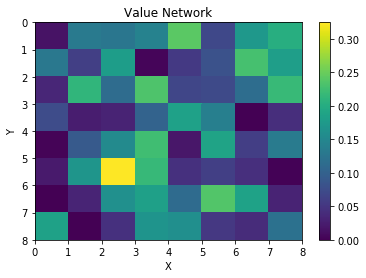

In [25]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            # And now have the critic model predict the state value
            # with the player in that location.
            value = critic_model.predict(my_state.reshape(1, OBSERVATION_SPACE))
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()


env.reset()
env.render()
plot_value(STATEGRID)

## Training Procedure

In [26]:
from IPython.display import clear_output
import random
import time

def trainer(epochs=1000, batchSize=40, 
            gamma=0.975, epsilon=1, min_epsilon=0.1,
            buffer=80):
    
    wins = 0
    losses = 0
    # Replay buffers
    actor_replay = []
    critic_replay = []
    wins_ws = 0
    losses_ws = 0
    warm_start=100
    
    for i in range(epochs):

        observation = env.reset()
        done = False
        reward = 0
        info = None
        move_counter = 0

        while(not done):
            # Get original state, original reward, and critic's value for this state.
            orig_state = to_onehot(OBSERVATION_SPACE,observation)
            orig_reward = reward
            orig_val = critic_model.predict(orig_state.reshape(1,OBSERVATION_SPACE))

            if (random.random() < epsilon): #choose random action
                action = np.random.randint(0,ACTION_SPACE)
            else: #choose best action from Q(s,a) values
                qval = actor_model.predict( orig_state.reshape(1,OBSERVATION_SPACE) )
                #print(qval)
                action = (np.argmax(qval))
                
            #Take action, observe new state S'
            new_observation, new_reward, done, info = env.step(action)
            new_state = to_onehot(OBSERVATION_SPACE,new_observation)
            # Critic's value for this new state.
            new_val = critic_model.predict(new_state.reshape(1,OBSERVATION_SPACE))
            
            if not done: # Non-terminal state.
                target = orig_reward + ( gamma * new_val)
            else:
                # In terminal states, the environment tells us
                # the value directly.
                target = orig_reward + ( gamma * new_reward )
            
            # For our critic, we select the best/highest value.. The
            # value for this state is based on if the agent selected
            # the best possible moves from this state forward.
            # 
            # BTW, we discount an original value provided by the
            # value network, to handle cases where its spitting
            # out unreasonably high values.. naturally decaying
            # these values to something reasonable.
            if new_reward <0:
                best_val = new_reward
            else:
                best_val = max((orig_val*gamma), target)
            # Now append this to our critic replay buffer.
            critic_replay.append([orig_state, best_val])
            # If we are in a terminal state, append a replay for it also.
            if done:
                critic_replay.append( [new_state, float(new_reward)] )
            
            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
            actor_delta = new_val - orig_val                
            actor_replay.append([orig_state, action, actor_delta])
                    
            # Critic Replays...
            while(len(critic_replay) > buffer): # Trim replay buffer
                critic_replay.pop(0)
            # Start training when we have enough samples.
            if(len(critic_replay) >= buffer):
                minibatch = random.sample(critic_replay, batchSize)
                X_train = []
                y_train = []
                for memory in minibatch:
                    m_state, m_value = memory
                    y = np.empty([1])
                    y[0] = m_value
                    X_train.append(m_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((1,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            
            # Actor Replays...
            while(len(actor_replay) > buffer):
                actor_replay.pop(0)                
            if(len(actor_replay) >= buffer):
                X_train = []
                y_train = []
                minibatch = random.sample(actor_replay, batchSize)
                for memory in minibatch:
                    m_orig_state, m_action, m_value = memory
                    old_qval = actor_model.predict( m_orig_state.reshape(1,OBSERVATION_SPACE,) )
                    y = np.zeros(( 1, ACTION_SPACE ))
                    y[:] = old_qval[:]
                    y[0][m_action] = m_value
                    X_train.append(m_orig_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((ACTION_SPACE,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)

            # Bookkeeping at the end of the turn.
            observation = new_observation
            reward = new_reward
            move_counter+=1
            if done:
                if new_reward > 0 : # Win
                    wins += 1
                else: # Loss
                    losses += 1
        if i == warm_start:
            wins_ws = deepcopy(wins)
            losses_ws = deepcopy(losses)
        # Finised Epoch
        clear_output(wait=True)
        print("Game #: %s" % (i,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
        print("Wins/Losses before WS %s/%s" % (wins_ws, losses_ws))
        if epsilon > min_epsilon:
            epsilon -= (1.0/epochs)  

In [19]:
from IPython.display import clear_output
import random
import time
from copy import deepcopy

def trainer(epochs=1000, batchSize=40, 
            gamma=0.975, epsilon=1, min_epsilon=0.1,
            buffer=80,policy=np.random.random((64,4))):
    
    wins = 0
    losses = 0
    
    wins_ws = 0
    losses_ws = 0
    # Replay buffers
    actor_replay = []
    critic_replay = []
    warm_start=100
    
    for i in range(epochs):

        observation = env.reset()
        done = False
        reward = 0
        info = None
        move_counter = 0

        while(not done):
            # Get original state, original reward, and critic's value for this state.
            orig_state = to_onehot(OBSERVATION_SPACE,observation)
            orig_reward = reward
            orig_val = critic_model.predict(orig_state.reshape(1,OBSERVATION_SPACE))
            
            #if i < warm_start:
            #    obs_predict = np.squeeze(orig_state)
            #    index, = np.where(obs_predict == 1.)
            #    action = np.argmax(policy[index,:])
            
            if (random.random() < epsilon): #choose random action
                action = np.random.randint(0,ACTION_SPACE)
            else:
                if i < warm_start:
                    obs_predict = np.squeeze(orig_state)
                    index, = np.where(obs_predict == 1.)
                    action = np.argmax(policy[index,:])
                else: #choose best action from Q(s,a) values
                    qval = actor_model.predict( orig_state.reshape(1,OBSERVATION_SPACE) )
                    action = (np.argmax(qval))
                
            #Take action, observe new state S'
            new_observation, new_reward, done, info = env.step(action)
            new_state = to_onehot(OBSERVATION_SPACE,new_observation)
            # Critic's value for this new state.
            new_val = critic_model.predict(new_state.reshape(1,OBSERVATION_SPACE))
            
            if not done: # Non-terminal state.
                target = orig_reward + ( gamma * new_val)
            else:
                # In terminal states, the environment tells us
                # the value directly.
                target = orig_reward + ( gamma * new_reward )
            
            # For our critic, we select the best/highest value.. The
            # value for this state is based on if the agent selected
            # the best possible moves from this state forward.
            # 
            # BTW, we discount an original value provided by the
            # value network, to handle cases where its spitting
            # out unreasonably high values.. naturally decaying
            # these values to something reasonable.
            if new_reward <0:
                best_val = new_reward
            else:
                best_val = max((orig_val*gamma), target)
            # Now append this to our critic replay buffer.
            critic_replay.append([orig_state, best_val])
            # If we are in a terminal state, append a replay for it also.
            if done:
                critic_replay.append( [new_state, float(new_reward)] )
            
            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
            actor_delta = new_val - orig_val                
            actor_replay.append([orig_state, action, actor_delta])
                    
            # Critic Replays...
            while(len(critic_replay) > buffer): # Trim replay buffer
                critic_replay.pop(0)
            # Start training when we have enough samples.
            if(len(critic_replay) >= buffer):
                minibatch = random.sample(critic_replay, batchSize)
                X_train = []
                y_train = []
                for memory in minibatch:
                    m_state, m_value = memory
                    y = np.empty([1])
                    y[0] = m_value
                    X_train.append(m_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((1,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            
            # Actor Replays...
            while(len(actor_replay) > buffer):
                actor_replay.pop(0)                
            if(len(actor_replay) >= buffer):
                X_train = []
                y_train = []
                minibatch = random.sample(actor_replay, batchSize)
                for memory in minibatch:
                    m_orig_state, m_action, m_value = memory
                    old_qval = actor_model.predict( m_orig_state.reshape(1,OBSERVATION_SPACE,) )
                    y = np.zeros(( 1, ACTION_SPACE ))
                    y[:] = old_qval[:]
                    y[0][m_action] = m_value
                    X_train.append(m_orig_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((ACTION_SPACE,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)

            # Bookkeeping at the end of the turn.
            observation = new_observation
            reward = new_reward
            move_counter+=1
            if done:
                if new_reward > 0 : # Win
                    wins += 1
                else: # Loss
                    losses += 1
        if i == warm_start:
            wins_ws = deepcopy(wins)
            losses_ws = deepcopy(losses)
        # Finised Epoch
        clear_output(wait=True)
        print("Game #: %s" % (i,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
        print("Wins/Losses before WS %s/%s" % (wins_ws, losses_ws))
        if epsilon > min_epsilon:
            epsilon -= (1.0/epochs)

In [31]:
%%time
trainer(epochs=1000,buffer=40,batchSize=30)

Game #: 999
Moves this round 14
Final Position:
  (Down)
HHFHFHFF
FFFFFFFF
SFFFFFFF
FFHFFFFF
FFFFFFHF
FFFFFFFF
FFFFFFFF
FFFFHFFG
Wins/Losses 415/585
Wins/Losses before WS 2/99
CPU times: user 9min 29s, sys: 1min 10s, total: 10min 40s
Wall time: 8min 33s


In [30]:
%%time
trainer(epochs=1000,buffer=30,batchSize=20,policy=gen_imgs)

TypeError: trainer() got an unexpected keyword argument 'policy'

### What the Value network has learned


HHFHFHFF
FFFFFFFF
SFFFFFFF
FFHFFFFF
FFFFFFHF
FFFFFFFF
FFFFFFFF
FFFFHFFG


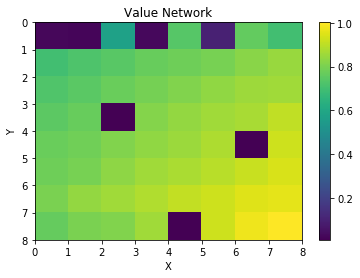

In [32]:
env.reset()
env.render()
plot_value(STATEGRID)


FFSFFFFF
FFFFFHFF
FFFFFFFH
FFHFFFFF
FFFFFHFF
FFFFFFHF
FFFFHFFF
FFFGFFFF


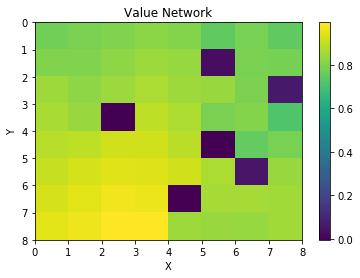

In [152]:
env.reset()
env.render()
plot_value(STATEGRID)

### Showing Policy

In [33]:
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    #working_state = initial_state.copy()
    #p = findLoc(working_state, np.array([0,0,0,1]))
   #working_state[p[0],p[1]] = np.array([0,0,0,0])
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            #for a in range(0, 4):
            my_state = initial_state.copy()
            my_state[x,y] = 1
            #
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            qval = actor_model.predict(obs_predict)
            #print(obs_predict)
            
            action = (np.argmax(qval))
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()
print(show_policy(STATEGRID))


HHFHFHFF
FFFFFFFF
SFFFFFFF
FFHFFFFF
FFFFFFHF
FFFFFFFF
FFFFFFFF
FFFFHFFG
[[u'>' u'v' u'^' u'v' u'v' u'v' u'v' u'>']
 [u'>' u'>' u'v' u'>' u'v' u'>' u'>' u'v']
 [u'>' u'v' u'>' u'>' u'v' u'v' u'v' u'v']
 [u'>' u'v' u'v' u'v' u'>' u'>' u'>' u'v']
 [u'>' u'v' u'>' u'>' u'>' u'v' u'v' u'v']
 [u'>' u'>' u'>' u'>' u'>' u'>' u'>' u'v']
 [u'>' u'>' u'>' u'>' u'>' u'>' u'>' u'v']
 [u'>' u'^' u'^' u'^' u'v' u'v' u'>' u'v']]


In [153]:
env.reset()
env.render()
print(show_policy(STATEGRID))


FFSFFFFF
FFFFFHFF
FFFFFFFH
FFHFFFFF
FFFFFHFF
FFFFFFHF
FFFFHFFF
FFFGFFFF
[[u'v' u'v' u'v' u'v' u'v' u'>' u'v' u'v']
 [u'v' u'v' u'v' u'v' u'v' u'^' u'^' u'^']
 [u'v' u'v' u'>' u'v' u'v' u'<' u'<' u'<']
 [u'v' u'<' u'>' u'v' u'v' u'^' u'v' u'<']
 [u'v' u'v' u'v' u'v' u'<' u'v' u'^' u'v']
 [u'v' u'v' u'v' u'v' u'<' u'<' u'>' u'>']
 [u'v' u'v' u'v' u'v' u'>' u'^' u'<' u'v']
 [u'>' u'>' u'>' u'<' u'v' u'v' u'>' u'v']]


In [120]:
def play(render_every_step=False):
    observation = env.reset()
    done = False
    reward = 0.0
    max_moves = 40
    move_counter = 0
    while not done and move_counter < max_moves:
        state = to_onehot(OBSERVATION_SPACE,observation)
        qval = actor_model.predict( state.reshape(1,OBSERVATION_SPACE) )
        action = (np.argmax(qval))
        observation, reward, done, info = env.step(action)
        #print(A2A[action])
        if render_every_step:
            env.render()
        move_counter += 1
    env.render()

play(render_every_step=False)

  (Down)
FFSFFFFF
FFFFFHFF
FFFFFFFH
FFHFFFFF
FFFFFHFF
FFFFFFHF
FFFFHFFF
FFFGFFFF


# Sampling from GENERATOR

In [16]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
#from time import sleep
import numpy as np
import pandas as pd
from sklearn import linear_model
import math
import gym
import myfrozen
import pickle
import img_utils
import os

from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, Lambda
from keras.layers.advanced_activations import LeakyReLU, Softmax
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras import backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/drl/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
import h5py
from keras.models import load_model

In [11]:
generator = load_model('models/policies/generator.h5')

/anaconda/envs/drl/lib/python2.7/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
def show_policy(q):
    A2A=['<','v','>','^']
    grid = np.zeros(64, dtype='<U2')
    for index in xrange(64):
        action = np.argmax(q[index,:])
        grid[index] = A2A[action]
    grid = np.reshape(grid, (8, 8), order='C')
    print(grid)
    return grid

for iteration in range(1):
    noise = np.random.normal(0, 1, (1, 64))
    gen_imgs = generator.predict(noise)
    _ = show_policy(np.squeeze(gen_imgs, axis=0))

[[u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'v' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'v' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'v' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'<' u'<' u'v']
 [u'<' u'^' u'<' u'<' u'<' u'<' u'<' u'<']]


In [13]:
gen_imgs = np.squeeze(gen_imgs, axis=0)